## Images 3D et 3D+t : segmentation d’IRM du cœur

Hamdaoui Aymane  
Duhazé Titouan

##### Imports

In [1]:
%matplotlib widget
import numpy as np
import cv2
import torchio as tio
from collections import deque
import json
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import skimage.morphology as mp;
import warnings
import matplotlib as mpl

##### ImageNavigator Class
Nous définissons un outil qui permis de naviguer entre les images de façon plus pratiques

In [2]:
# Désactiver les avertissements de matplotlib
mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter("ignore", category=UserWarning)

class ImageNavigator:
    def __init__(self, data, type="slice"):
        self.data = data
        self.num_slices = data.shape[0]  
        self.current_index = 0

        # Initialize figure and axes
        self.fig, self.ax = plt.subplots()
        self.update_image(type)  
        self.ax.axis('off')

        # Add buttons for navigation
        axprev = plt.axes([0.7, 0.01, 0.1, 0.075])
        axnext = plt.axes([0.81, 0.01, 0.1, 0.075])
        self.bprev = Button(axprev, 'Previous')
        self.bnext = Button(axnext, 'Next')
        self.bprev.on_clicked(lambda event: self.prev_image(event, type))
        self.bnext.on_clicked(lambda event: self.next_image(event, type))        
        plt.show()

    def save_image(self, event):
        """Save the current image to a file."""
        filename = f'image_{self.current_index}.png'
        plt.imsave(filename, self.data[self.current_index, :, :], cmap='gray' if self.data.ndim == 3 else None)
        print(f'Saved image {filename}')

    def update_image(self, type):
        """Update the image according to the current slice index and image type."""
        
        # Effacer l'ancienne image
        self.ax.cla()  # Clear the axis
        
        # Réaffichage de l'image
        if self.data.ndim == 3:  # Handle grayscale image
            self.image = self.ax.imshow(self.data[self.current_index, :, :], cmap='gray')
        elif self.data.ndim == 4:  # Handle RGBA image
            self.image = self.ax.imshow(self.data[self.current_index, :, :, :])  # RGBA, no cmap needed
        
        self.ax.set_title(f'{type}: {self.current_index}')
        self.ax.axis('off')  # Ensure axes are turned off
        self.fig.canvas.draw()

    def prev_image(self, event, type):
        if self.current_index > 0:
            self.current_index -= 1
            self.update_image(type)

    def next_image(self, event, type):
        if self.current_index < self.num_slices - 1:
            self.current_index += 1
            self.update_image(type)

def bulk_plot(data):
    nav = ImageNavigator(data)
    return nav

In [3]:
def patient_info(patient_id):
        ''' Return a dictionary with patient information from the Info.cfg file:
            ED: int; 
            ES: int;
            Group: DCM/HCM/NOR/MINF/RV; 
            Height: float; 
            NbFrame: int;
            Weight: float;
            '''
        if int(patient_id) < 101:
            filename = f"../../database/training/patient{patient_id}/Info.cfg"
        elif 100 <int(patient_id) < 151:
            filename = f"../../database/testing/patient{patient_id}/Info.cfg"
        else:
            print("Patient ID must be between 001 and 150.")
            return
        
        info_dict = {}
        with open(filename, 'r') as file:
            for line in file:
                key, value = line.strip().split(': ')
                if key=="ED" or key=="ES":
                    value = int(value)
                info_dict[key] = value

        return info_dict

##### IRM class
Simple définition d'un objet IRM et de ses attributs afin de mieux structurer notre code

In [4]:
class Irm():
    def __init__(self,patient_id):
        self.patient_id = patient_id
        try:
            self.image = tio.ScalarImage(f"../../database/training/patient{patient_id}/patient{patient_id}_4d.nii.gz")
        except:
            self.image = tio.ScalarImage(f"../../database/testing/patient{patient_id}/patient{patient_id}_4d.nii.gz")

        ### Patient information ###
        self.data = self.image.data.numpy()                         # 4D image data
        self.shape = self.data.shape                                # Shape of the 4D image
        self.middle_slice = self.data.shape[-1]//2                  # Middle slice index
        self.info = patient_info(patient_id)                        # Patient information
        self.t_ED = patient_info(self.patient_id)["ED"]-1           # End-diastolic time index
        self.t_ES = patient_info(self.patient_id)["ES"]-1           # End-systolic time index

        ### Seed points ###
        self.initial_seed_point = None                              # Initial seed point
        self.seed_points = {}                                       # Seed points for each layer index

        self.images_processed = []

        ### Set of slices and times for Navigation ###
        self.set_of_slices = {}                                     # key: time index, value: array of slices
        self.set_of_times = {}                                      #key: layer index, value: array of times
        for k in range(self.data.shape[0]):
            self.set_of_slices[k] = np.array([self.data[k,:,:,i] for i in range(self.data.shape[3])])
        for k in range(self.data.shape[3]):
            self.set_of_times[k] = np.array([self.data[i,:,:,k] for i in range(self.data.shape[0])])

        ### Metrics ###
        try:
            self.gt1 = tio.ScalarImage(f"../../database/training/patient{patient_id}/patient{patient_id}_frame01_gt.nii.gz").data.numpy()
        except:
            self.gt1 = tio.ScalarImage(f"../../database/testing/patient{patient_id}/patient{patient_id}_frame01_gt.nii.gz").data.numpy()
        self.mean_dice = None

    def show_slices(self, time_index):
        """this function plots all layers of the 4D image at a specific time index"""
        nav = ImageNavigator(self.set_of_slices[time_index])
        return nav
    
    def show_times(self, layer_index):
        """this function plots all time indexes of the 4D image at a specific layer index"""
        nav = ImageNavigator(self.set_of_times[layer_index],type="time")
        return nav

##### Example of use of the IRM Class

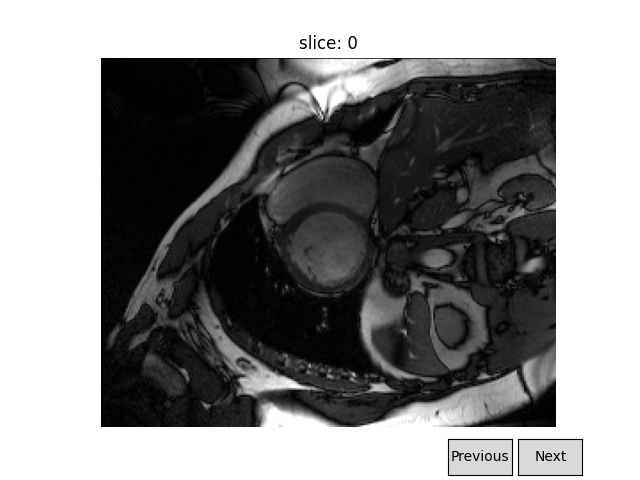

In [5]:
irm=Irm("020")
irm.show_slices(0)

##### Tools panel

In [ ]:
def absolute_difference_Ed_ES(patient_id,slice_index):
    '''Return the absolute difference between the end-diastolic and end-systolic images for a given patient and slice index.'''
    if int(patient_id) < 101:
        image = tio.ScalarImage(f"../../database/training/patient{patient_id}/patient{patient_id}_4d.nii.gz")
    elif 100 < int(patient_id) < 151:
        image = tio.ScalarImage(f"../../database/testing/patient{patient_id}/patient{patient_id}_4d.nii.gz")
    else:
        print("Patient ID must be between 001 et 150.")
        return
    # Calculer la différence en valeurs absolues
    data = image.data.numpy()
    image1 = data[patient_info(patient_id)["ED"], :, :, slice_index]
    image2 = data[patient_info(patient_id)["ES"], :, :, slice_index]
    abs_diff = np.abs(image1 - image2)
    
    return abs_diff

def dilate(img, region, mask):
    '''For a given binary image, a region and a mask .Return the dilated region.'''
    mask = np.array(mask)# S'assurer que le masque est un tableau numpy
    mask_shape = mask.shape
    shape = img.shape
    copy = np.zeros(shape, dtype=np.int32)
    
    # Marquer les points de la région initiale dans 'copy'
    for x, y in region:
        copy[x, y] = 1
    # Calcul de l'offset en fonction de la taille du masque
    offset_x = mask_shape[0] // 2
    offset_y = mask_shape[1] // 2

    # Appliquer le masque de dilatation
    for x, y in region:
        for i in range(mask_shape[0]):
            for j in range(mask_shape[1]):
                if mask[i, j] == 1:                                         # Vérifier la position du masque
                    nx, ny = x + i - offset_x, y + j - offset_y
                    # Vérifier les limites de l'image
                    if 0 <= nx < shape[0] and 0 <= ny < shape[1]:
                        if copy[nx, ny] == 0:                               # Ajouter les points dilatés à 'new_region' si non déjà présents
                            copy[nx, ny] = 1                                # Marquer dans 'copy' pour éviter de repasser dessus
    new_region = np.argwhere(copy == 1).tolist()
    return new_region   

def erode(img, region, mask):
    '''For a given binary image, a region and a mask .Return the eroded region.'''
    mask = np.array(mask)                                                   # S'assurer que le masque est un tableau numpy
    mask_shape = mask.shape
    shape = img.shape
    copy = np.zeros(shape, dtype=np.int32)
    new_region = set()                                                      # Nouvel ensemble pour stocker la région érodée
    
    # Marquer les points de la région initiale dans 'copy'
    for x, y in region:
        copy[x, y] = 1

    # Calcul de l'offset pour centrer le masque autour de chaque point
    offset_x = mask_shape[0] // 2
    offset_y = mask_shape[1] // 2

    # Appliquer le masque d'érosion
    for x, y in region:
        erode_point = True                                                  # On suppose que le point peut rester dans la région érodée
        for i in range(mask_shape[0]):
            for j in range(mask_shape[1]):
                if mask[i, j] == 1:                                         # Position du masque à vérifier
                    nx, ny = x + i - offset_x, y + j - offset_y
                    # Si un voisin hors de la région est trouvé, on enlève le point
                    if not (0 <= nx < shape[0] and 0 <= ny < shape[1] and copy[nx, ny] == 1):
                        erode_point = False
                        break
            if not erode_point:
                break
        # Si tous les voisins dans le masque sont dans la région, on garde le point
        if erode_point:
            new_region.add((x, y))
    
    return new_region

def close(img, region, mask):
    '''For a given binary image, a region and a mask .Return the closed region.'''
    return erode(img, dilate(img, region, mask), mask)

def region_growing_adaptive(irm, t,x ,y ,z, Nb_dilate=3,threshold=3, filtered=False, nb_neighbours=8):
    '''For a given 4D image, a time index, a seed point and a slice index, return the region grown around the seed point.'''
    # Applique un filtre bilatéral
    if filtered:
        image_32f = irm.data[t,:,:,z].astype(np.float32)
        working_set = cv2.bilateralFilter(image_32f, 15, 50, 60)

    else:
        working_set = irm.data[t,:,:,z]
    initial_x,initial_y = x,y
    to_explore = [(x,y)]
    explored = []
    edge= []
    region=[(x,y)]
    image_processed = irm.data[t,:,:,z]
    while to_explore:
        if len(explored)>2500:  # Si la région est trop grande, réinitialise --> évite les boucles infinies et permet de diminuer le threshold
            to_explore = [(initial_x,initial_y)]
            explored = []
            edge= []
            region=[(initial_x,initial_y)]
            threshold-=1
        x,y = to_explore.pop(0)                                                 # Prendre le premier élément de la liste
        if not -1< x < irm.data.shape[1] or not -1< y < irm.data.shape[2]:      # Vérifier que les coordonnées sont dans les limites de l'image
            raise ValueError("Coordinates are out of bounds.")
        if nb_neighbours == 4:
            neighbours = [(x+1,y),(x-1,y),(x,y+1),(x,y-1)]
        elif nb_neighbours == 8:
            neighbours = [(x+1,y),(x-1,y),(x,y+1),(x,y-1), (x+1,y+1),(x-1,y-1),(x+1,y-1),(x-1,y+1)]
        for couple in neighbours:
            if couple not in explored and couple not in edge and -1<couple[0]<irm.data.shape[1] and -1<couple[1]<irm.data.shape[2]: # Vérifier que le point n'a pas déjà été exploré
                if abs(working_set[x,y] -working_set[couple[0],couple[1]]) < threshold:     # Vérifier que la différence de gris est inférieure au seuil
                    to_explore.append(couple)
                    region.append(couple)                            # Ajouter le point à la région
                else:
                    edge.append(couple)
            else:
                continue 
            explored.append(couple)
    mask = mp.disk(Nb_dilate)
    region = close(working_set,region,np.ones((8,8)))   #utilisation d'un mask volontairement très grand afin de s'assurer de la fermeture
    region = dilate(working_set,region,mask)    

    region = np.array(region)
    
    #Cette partie permet de dessiner l'enveloppe convexe de la région, elle utilise des outils d'autres modules mais la logique est la notre
    contour = region.reshape((-1,1,2))
    hull = cv2.convexHull(contour)
    image = np.zeros((irm.shape[1], irm.shape[2], 3), dtype=np.uint8) 
    cv2.drawContours(image, [hull], -1, (255, 255, 255), thickness=-1)
    # Dessine l'enveloppe convexe sur l'image
    cv2.drawContours(image, [hull], -1, (255), thickness=-1)
    np.column_stack(np.where(image > 0))
    new_region = np.column_stack(np.where(image > 0))
    region = np.array([(y, x) for x, y,z in new_region.tolist()])

    if image_processed.dtype == 'float32': #renormalisation de l'image
        image_processed = 255 * (image_processed - np.min(image_processed)) / (np.max(image_processed) - np.min(image_processed))
        image_processed = image_processed.astype(np.uint8)
    image_rgb = np.stack((image_processed,)*3, axis=-1)
    image_rgba = np.dstack((image_rgb, np.ones(image_rgb.shape[:2], dtype=np.uint8) * 255))
    for couple in region:   #coloration de la région
        try:
            # Extraire la valeur de gris d'origine
            gray_value = image_rgba[couple[0], couple[1], 0]  # La valeur de gris (R = G = B)

            # Calculer un facteur pour amplifier la couleur dans les zones claires
            amplification_factor = 1 + (gray_value*128 / 255)  # Plus la zone est blanche, plus le facteur est grand

            # Appliquer une teinte plus marquée et ajuster l'intensité
            new_red = min(255, gray_value * (1 - 0.3) + 220 * amplification_factor)  # Accentuer le rouge
            new_green = min(255, gray_value * (1 - 0.6))  # Maintenir une proportion de vert faible
            new_blue = min(255, gray_value * (1 - 0.6))  # Maintenir une proportion de bleu faible

            # Ajuster l'opacité pour rendre les couleurs plus visibles
            new_alpha = 200  # Augmenter légèrement l'opacité pour plus de contraste

            # Mettre à jour la couleur et l'alpha
            image_rgba[couple[0], couple[1]] = [0, new_green, new_blue, new_alpha]
        except:
            print(f"Error at {couple}.")
    return image_rgba,region,threshold

def get_window(image,x,y,w=35):
    """Returns a window of size 2w around the pixel (x,y) in the image."""
    windowed = image[x-w:x+w,y-w:y+w]
    """ plt.imshow(windowed)
    plt.show() """
    return windowed

def find_indices_within_range(lst, percent, epsilon):
    """
    Trouve les indices min et max d'une liste pour les valeurs entre percent-epsilon et percent+epsilon.
    
    :param lst: Liste de valeurs (liste ou tableau numpy).
    :param percent: Valeur centrale.
    :param epsilon: Tolérance autour de percent.
    :return: Indices minimum et maximum des éléments satisfaisant la condition, ou (None, None) si aucun trouvé.
    """
    # Définir la plage de recherche
    lower_bound = percent - epsilon
    upper_bound = percent + epsilon
    
    # Trouver les indices des éléments satisfaisant la condition
    indices = [i for i, value in enumerate(lst) if lower_bound <= value <= upper_bound]
    
    if indices:
        return min(indices), max(indices)
    else:
        return None, None  # Aucun élément trouvé dans la plage
    
def get_barycentre(grayscale_image):
    """
    Calcule le barycentre d'une image en niveaux de gris.

    Parameters:
        grayscale_image (numpy.ndarray): Image en niveaux de gris.

    Returns:
        tuple: Coordonnées (x_barycentre, y_barycentre).
    """
    # Vérifier si l'image est vide (tous les pixels à 0)
    if np.sum(grayscale_image) == 0:
        return None

    # Créer une grille de coordonnées
    y_indices, x_indices = np.indices(grayscale_image.shape)

    # Calculer les coordonnées pondérées par l'intensité des pixels
    total_intensity = np.sum(grayscale_image)
    x_barycentre = np.sum(x_indices * grayscale_image) / total_intensity
    y_barycentre = np.sum(y_indices * grayscale_image) / total_intensity

    return (y_barycentre, x_barycentre)

def hough(closed_image, rayons_test,bar, thickness=1):
    """Apply an Hough like transform to detect circles in the image. Not exactly Hough but the same idea and requires less computation time"""
    shape = closed_image.shape
    # Initialisation de l'image d'accumulation
    ima_intens = np.zeros((len(rayons_test), shape[0], shape[1]))
    # Récupération des coordonnées des points d'intérêt (pixels blancs)
    points = np.column_stack(np.where(closed_image == 255))
    for i, r in enumerate(rayons_test):
        if r < 1:
            pass
        for a, b in points:
            mask = np.zeros(shape, dtype=np.uint8)
            cv2.circle(mask, (b, a), r, 255, thickness)                                             # Tracer un cercle autour du point (b, a) avec le rayon r
            ima_intens[i][mask == 255] += 1/(1+r/2)/(np.sqrt((a-bar[0])**2+(b-bar[1])**2)+1)        # Augmenter l'accumulateur pour chaque pixel du cercle

    r_ind, x, y = np.unravel_index(np.argmax(ima_intens), ima_intens.shape)                         # Trouver le maximum dans l'accumulateur
    r = rayons_test[r_ind]                                                                          # Récupérer le rayon correspondant
    return x, y, r

def get_initial_seed(irm,data):
    N = irm.data.shape[-1]
    values = []
    epsilon = 0.05
    x_padd = irm.data.shape[1] / 10
    y_padd = irm.data.shape[2] / 10

    data_percents = data["x"]
    data_rayons = data["y"]

    abs = np.abs(irm.data[irm.t_ED, :, :, 0] - irm.data[irm.t_ES, :, :, 0]).astype('uint8')
    abs = cv2.bilateralFilter(abs, 3, 75, 200)
    working_set = abs.astype('uint8')

    x_bar, y_bar = get_barycentre(working_set)
    pixel_2 = abs.shape[0]*abs.shape[1]

    for slices in range(N):
        percent = slices / N

        # Récupérer les indices des rayons pertinents
        ind_min, ind_max = find_indices_within_range(data_percents, percent, epsilon)
        rayons_utiles = data_rayons[ind_min:ind_max]
        rayons_utiles = np.array(rayons_utiles)
        rayons_utiles = np.round(np.sqrt(rayons_utiles*pixel_2)).astype(int)
        if len(rayons_utiles) == 0: 
            continue  # Ignorer si aucun rayon pertinent

        r_min, r_max = min(rayons_utiles), max(rayons_utiles) + 10
        r_mean = np.mean(rayons_utiles)
        variance = np.std(rayons_utiles)

        # Générer des rayons avec des pas adaptés
        rayons_test = sorted(set(range(r_min, r_max + 1, 3)) | 
                             set(range(max(r_min, int(r_mean - 2 * np.sqrt(variance))),
                                       min(r_max, int(r_mean + 2 * np.sqrt(variance))) + 1, 1)))

        # Prétraitement de l'image
        abs = np.abs(irm.data[irm.t_ED, :, :, slices] - irm.data[irm.t_ES, :, :, slices]).astype('uint8')
        abs = cv2.bilateralFilter(abs, 3, 75, 200)
        roi = get_window(abs, int(x_bar), int(y_bar))
        working_set = roi.astype('uint8')

        # Détection des contours avec Canny
        std = np.std(working_set) 
        if std < 10:
            lowThresh = 15*std
        elif 10 <= std < 26:
            lowThresh = 20*std
        else:
            lowThresh = 15*std
        
        edges = cv2.Canny(working_set, lowThresh/1.5, lowThresh*2)
        nb_non_zero = np.count_nonzero(edges)
        while nb_non_zero < 250:
            lowThresh = lowThresh-15
            edges = cv2.Canny(working_set, lowThresh, lowThresh*3)
            nb_non_zero = np.count_nonzero(edges)

        # Appel à hough
        x2, y2, r = hough(edges, rayons_test, (x_bar, y_bar))
        x = x2 + int(x_bar) - 35
        y = y2 + int(y_bar) - 35

        # Vérification de la distance
        
        if np.sqrt((x - x_bar) ** 2 + (y - y_bar) ** 2) <= np.sqrt(x_padd ** 2 + y_padd ** 2):
            values.append((x, y))
    return values

In [7]:
try:
    with open('rayons_opti.json', "r") as file:
        radius_data = json.load(file)
except FileNotFoundError:
    pass

##### Principal Function

In [8]:
def main(irm,show=False,filtered=False):
    if int(irm.patient_id) < 101:
        pass
    elif 100 < int(irm.patient_id) < 151:
        pass
    else:
        print("Patient ID must be between 001 et 150.")
        return
    
    temporary_dictionnary = {} #used to store slices in the right order
    data = irm.data
    middle_slice_index = irm.middle_slice

    values = get_initial_seed(irm,radius_data,show=False)
    x = np.median([val[0] for val in values])
    y = np.median([val[1] for val in values])
    initial_seed_point = [(int(x),int(y))]
    if len(initial_seed_point) > 1:
        raise ValueError(f"Plusieurs cercles detectes : {len(initial_seed_point)}")
        

    t_ED = irm.t_ED
    t_ES = irm.t_ES
    irm.seed_points={(t_ED,middle_slice_index):initial_seed_point[0],(t_ES,middle_slice_index):initial_seed_point[0]}
    center_y,center_x=irm.seed_points[(t_ED,middle_slice_index)]
    center_x,center_y = int(center_x),int(center_y)

    #irm.images_processed.append(tmp)
    to_process=[(t_ED,middle_slice_index),(t_ED,middle_slice_index+1),(t_ED,middle_slice_index-1)]
    memo = [(t_ED,middle_slice_index)]
    threshold = 30
    while to_process:
        current_time, current_slice = to_process.pop(0)
        memo.append((current_time,current_slice))
        center_x,center_y = irm.seed_points[(current_time,current_slice)]
        center_x,center_y = int(center_x),int(center_y)
        image_segmented,region,threshold_ = region_growing_adaptive(irm,current_time,int(center_x),int(center_y),current_slice,threshold=threshold,filtered=filtered, nb_neighbours=4)
        if current_slice == middle_slice_index:
            threshold = threshold_+5

        image_segmented[center_x,center_y] = [0,0,255,255]
    

        temporary_dictionnary[(current_time,current_slice)] = image_segmented
        A = np.zeros((irm.data.shape[1], irm.data.shape[2]))
        for couple in region:
            try:
                y, x = couple[1], couple[0]
                A[x, y] = 1
            except:
                pass
        bar = get_barycentre(A)
        if current_slice+1<data.shape[-1] and (current_time,current_slice+1) not in memo and (current_time,current_slice+1) not in to_process:
            to_process.append((current_time,current_slice+1))
        if current_slice-1>=0 and (current_time,current_slice-1) not in memo and (current_time,current_slice-1) not in to_process:
            to_process.append((current_time,current_slice-1))


        if current_slice == middle_slice_index:
            irm.seed_points[(current_time,current_slice+1)]=bar
            irm.seed_points[(current_time,current_slice-1)]=bar

        elif 0<current_slice<middle_slice_index:
            irm.seed_points[(current_time,current_slice-1)]=bar
        elif current_slice>middle_slice_index:
            irm.seed_points[(current_time,current_slice+1)]=bar

        image_segmented[int(bar[0]),int(bar[1])] = [255,0,0,255]


    for k in range(irm.data.shape[-1]):
        irm.images_processed.append(temporary_dictionnary[(t_ED,k)])
    if show:
        irm.images_processed = np.array(irm.images_processed)
        bulk_plot(irm.images_processed)
    return 

##### Example of use of the principal function

4


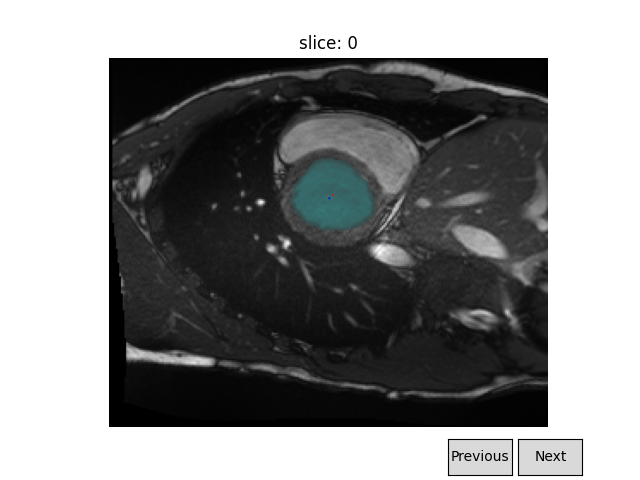

In [25]:
irm = Irm("078")
print(irm.middle_slice)
main(irm,show=True,filtered=True)

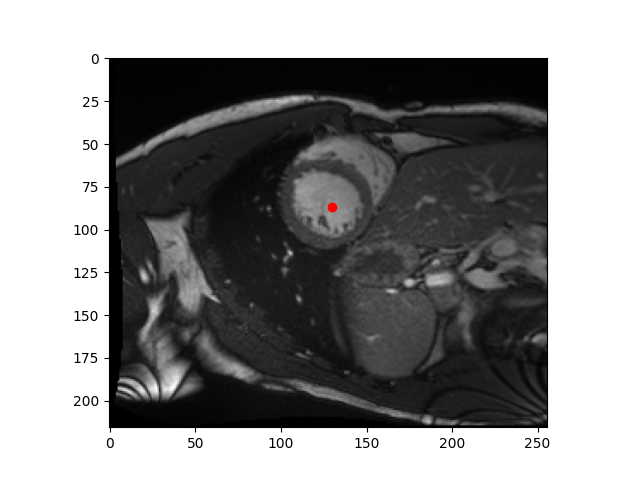

In [26]:
seed = irm.seed_points[(irm.t_ED,irm.middle_slice)]
plt.figure()
plt.imshow(irm.data[irm.t_ED,:,:,irm.middle_slice],cmap='gray')
plt.scatter(seed[1],seed[0],c='r')
plt.show()